In [1]:
from comut import comut
from comut import fileparsers
import palettable
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import math
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# mapping of mutation type to color. Only these mutation types are shown. Can be any valid matplotlib color, e.g. 'blue', #ffa500, or (1,1,1).
balance_6 = palettable.cmocean.diverging.Balance_6.mpl_colors
safe_10 = palettable.cartocolors.qualitative.Safe_10.mpl_colors
vivid_10 = palettable.cartocolors.qualitative.Vivid_10.mpl_colors
purp_7 = palettable.cartocolors.sequential.Purp_7.mpl_colormap
blue_seq = palettable.scientific.sequential.Devon_18.mpl_colors
gray_seq = palettable.scientific.sequential.GrayC_20.mpl_colors

mut_mapping = {'Missense': blue_seq[12], "Missense_Mutation": blue_seq[12],       # light blue
               'Nonsense':  blue_seq[7], "Nonsense_Mutation" : blue_seq[7], "stop_lost" : "#2200ff", "stop_gained" : "#2200ff",           # blue"#2200ff"
               'In frame indel': "#ea00ff", 'Frameshift indel': "#ea00ff",                   # purple 
               'Splice site' : "#ff842b", 'Splice_Site': "#ff842b", 'splice_acceptor_variant' :"#ff842b", 'splice_donor_variant'  :"#ff842b",   #orange
               "enhancer" : "#fff485", "promoter" : "#9e8d51", "noncoding" : "#fffac4", 
               "CTCF_binding_site" : "yellow", "CTCF_binding_site" : "yellow",               # yellow
               "TF_binding_site" : "#69ff73", "TF_binding_site_variant" : "#69ff73",       # light green
               "multiple_meaningless" : "gray"}
mut_sv_mapping = {"Reg_DEL" : gray_seq[6],  "Exon_DEL" : gray_seq[12], "SE_DEL" : gray_seq[15],  "Large_DEL" : gray_seq[19],  "duplication_P" : gray_seq[15], "duplication_SE" : gray_seq[18]}

Variant_Classification = list(mut_mapping.keys())
Variant_Classification_coding = ['Missense',  'Missense_Mutation',  'Nonsense',  'Nonsense_Mutation',  'stop_lost',  'stop_gained',  'In frame indel',  'Frameshift indel',  'Splice site',  'Splice_Site',  'splice_acceptor_variant',  'splice_donor_variant']
Variant_Classification_noncoding = [ 'enhancer',  'promoter',   'noncoding',  'CTCF_binding_site',  'TF_binding_site',  'TF_binding_site_variant',  'multiple_meaningless']
Variant_Classification_SV = [ 'deletion_E',  'duplication_E', "deletion_SE", "duplication_SE", "deletion_P", "duplication_P"]


pLI_df = pd.read_csv("/home/goldpm1/resources/pLI_by_gene.txt",sep = "\t", names = ["Hugo_Symbol", "pLI_score", "3", "4", "5", "6", "7"])
pLI_df = pLI_df[["Hugo_Symbol", "pLI_score"]]
matrix = []
pLI_df = pLI_df.append(pd.DataFrame.from_records(matrix, columns = ["Hugo_Symbol", "pLI_score"])).reset_index(drop = True)

In [2]:
def codingregion_filter (tt):
    pp1= tt["Polyphen2_HDIV_pred"].str.count("D") * 3 + tt["Polyphen2_HDIV_pred"].str.count("P") * 1 + tt["Polyphen2_HDIV_pred"].str.count("B") * 0
    pp2 = tt["Polyphen2_HDIV_pred"].str.count("D") * 1 + tt["Polyphen2_HDIV_pred"].str.count("P") * 1 + tt["Polyphen2_HDIV_pred"].str.count("B") * 1
    pp3 = pp1/pp2
    pp3[pp3.isna()] = 999
    tt["Polyphen2_HDIV"] = pp3

    pp1= tt["Polyphen2_HVAR_pred"].str.count("D") * 3 + tt["Polyphen2_HVAR_pred"].str.count("P") * 1 + tt["Polyphen2_HVAR_pred"].str.count("B") * 0
    pp2 = tt["Polyphen2_HVAR_pred"].str.count("D") * 1 + tt["Polyphen2_HVAR_pred"].str.count("P") * 1 + tt["Polyphen2_HVAR_pred"].str.count("B") * 1
    pp3 = pp1/pp2
    pp3[pp3.isna()] = 999
    tt["Polyphen2_HVAR"] = pp3
      
    pp1= tt["FATHMM_pred"].str.count("D") * 3 + tt["FATHMM_pred"].str.count("T") * 0
    pp2 = tt["FATHMM_pred"].str.count("D") * 1 + tt["FATHMM_pred"].str.count("T") * 1
    pp3 = pp1/pp2
    pp3[pp3.isna()] = 999
    tt["FATHMM"] = pp3

    pp1= tt["SIFT_pred"].str.count("D") * 2 + tt["SIFT_pred"].str.count("T") * 0
    pp2 = tt["SIFT_pred"].str.count("D") * 1 + tt["SIFT_pred"].str.count("T") * 1
    pp3 = pp1/pp2
    pp3[pp3.isna()] = 999
    tt["SIFT"] = pp3
    
    pp1= tt["DANN_score"].str.count("D") * 2 + tt["DANN_score"].str.count("T") * 0
    pp2 = tt["DANN_score"].str.count("D") * 1 + tt["DANN_score"].str.count("T") * 1
    pp3 = pp1/pp2
    pp3[pp3.isna()] = 999
    tt["DANN"] = pp3


    #["Polyphen2_HDIV", "Polyphen2_HVAR", "MutationTaster_pred", "FATHMM", "SIFT"]
    tt["MutationAssessor_pred"] = tt["MutationAssessor_pred"].replace(".", -9)
    tt["MutationTaster_pred"] = tt["MutationTaster_pred"].replace(".", -9)
    tt["MetaSVM_score"] = tt["MetaSVM_score"].replace(".", -9)
    tt["GERP++_RS"] = tt["GERP++_RS"].replace(".", -9); tt["GERP++_RS"] = tt["GERP++_RS"].replace("GERP++_RS", -9)
    tt["SpliceAI_score"] = tt["SpliceAI_score"].replace(".", -9);   tt["SpliceAI_score"].fillna(0, inplace = True)
    tt["check_db"] = None
    tt["check_db_Total"] = 0

    try:
        tt = tt.astype ({'MutationAssessor_pred':'float', 'MutationTaster_pred':'float', 'MetaSVM_score':'float', 'GERP++_RS':'float',  'SpliceAI_score':'float', "CLIN_SIG":"str", "clinvar_clnsig":"str" })
    except:
        print ("뭐가 문제지?")
        print (tt)

    for row in range (len (tt)):
        check_db = {"SIFT" : 0, "Polyphen2" : 0, "DANN" : 0, "FATHMM" : 0,  "MutationAssessor" : 0, "MutationTaster" : 0, "MetaSVM" : 0, "Total" : 0 }   # 채점표
        if tt.loc[row, "SIFT"] >= 1:
            check_db["SIFT"] = 1
        if (tt.loc[row, "Polyphen2_HDIV"] >= 1.5) | (tt.loc[row, "Polyphen2_HVAR"] >= 1.5):
            check_db["Polyphen2"] = 1
        if tt.loc[row, "DANN"] >= 1:
            check_db["DANN"] = 1
        if tt.loc[row, "FATHMM"] >= 1:
            check_db["FATHMM"] = 1
        if tt.loc[row, "FATHMM"] >= 2:
            check_db["FATHMM"] = 2
        if tt.loc[row, "MutationAssessor_pred"]  > 0.98:
            check_db["MutationAssessor"] = 1
        if tt.loc[row, "MutationTaster_pred"]  > 0.5:
            check_db["MutationTaster"] = 1
        if tt.loc[row, "MetaSVM_score"]  > 0.5:
            check_db["MetaSVM"] = 1
        check_db["Total"] = check_db["SIFT"] + check_db["Polyphen2"]  + check_db["DANN"]  + check_db["FATHMM"] + check_db["MutationAssessor"] + check_db["MutationTaster"] + check_db["MetaSVM"]
        
        #tt.loc[row, "check_db"] = check_db.items()
        tt.loc[row, "check_db_Total"] = check_db["Total"]
        

    t1 = tt [ (tt["CLIN_SIG"].str.contains("benign") == False) &
                (tt["CLIN_SIG"].str.contains("Benign") == False) &
                (tt["clinvar_clnsig"].str.contains("Benign") == False) &
                (tt["clinvar_clnsig"].str.contains("benign") == False) &
                #(tt["clinvar_clnsig"].str.contains("Uncertain_significance") == False) &
                (tt["check_db_Total"] > 4)    ]
    t1.insert (loc = 0, column="source", value = "t1")   

    t2 = tt [ ((tt["CLIN_SIG"].str.contains("Pathogenic") == True) |  (tt["CLIN_SIG"].str.contains("pathogenic") == True)  | (tt["CLIN_SIG"].str.contains("likely_pathogenic") == True)  )    ]
    t2.insert (loc = 0, column="source", value = "t2")

    t3 = tt [ (tt["SpliceAI_score"] >= 0.5)  ]
    t3.insert (loc = 0, column="source", value = "t3")

    t4 = tt [ (tt["Impact"] == "HIGH") & (tt["Depth"] > 10)      ]
    t4.insert (loc = 0, column="source", value = "t4")
        
    t_final = pd.concat([t1, t2, t3, t4]).drop_duplicates()
    
    t_final = t_final[t_final["BIOTYPE"] == "protein_coding"]


    # clinvar에 의해 엄격하게 cut
    # t_final = t_final[ (t_final["clinvar_clnsig"].str.contains("benign") == False) &  (t_final["clinvar_clnsig"].str.contains("Benign") == False) & (t_final["clinvar_clnsig"].str.contains("Uncertain_significance") == False)]
    
    return(tt)

def check_noncoding (check_db, threshold_totalscore, threshold_count):
    check = "FAIL"
    if sum(list(check_db.values())) >= threshold_totalscore:    # 총합 점수를 기준으로 판단
        check = "PASS"
    if ( len(check_db) - ( list(check_db.values()).count(0) )  )  >= threshold_count :  # 항목 개수를 기준으로 판단
        check = "PASS"
    return check

def noncodingregion_filter (tt, mutation_data_exon):
    filtered_row = []

    for row in range (len (tt)):
        check_db = {"RegulomeDB" : 0, "Fathmm_MKL" : 0, "GH+Ensembl" : 0, "GreenDB" : 0,  "regBase" : 0}   # 채점표

        #1. Regulome DB (2점 만점)
        if (tt.loc[row, "ranking_probability"] != ".")  & (isinstance(tt.loc[row, "ranking_probability"], str) == True):
            if float( tt.loc [row, "ranking_probability"][0] ) >= 0.5 :   # 3a 이런 것도 있어서 맨 앞의 글자만 숫자로 변환
                check_db ["RegulomeDB"] = 1
        for keys in ["ChIP", "DNase", "PWM", "Footprint", "QTL", "PWM_matched", "Footprint_matched"]:
            if tt.loc[row, keys] != '.':
                check_db["RegulomeDB"] = check_db["RegulomeDB"] + 0.1
        check_db["RegulomeDB"] = round(check_db["RegulomeDB"])

        #2. Fathmm_MKL (2점 만점)         #Coding_Score가 높으면 빼는 전략도 괜찮아 보임
        if tt.loc[row,"Non_Coding_Score"] != '.':
            if float ( tt.loc[row, "Non_Coding_Score"] ) >= 0.8 :
                check_db ["Non_Coding_Score"] = 2
            elif float ( tt.loc [row, "Non_Coding_Score"] ) >= 0.5 :
                check_db ["Non_Coding_Score"] = 1

        #3. GH+Ensembl
        for GH_Ensembl in ["EA_enhancer", "GH_promoter", "GH_enhancer", "RefSeq_promoter", "GH_promoter_enhancer", "ENSEMBL_promoter"]:
            if tt.loc[row, GH_Ensembl] != ".":       # 뭐라도 있으면 1점 추가.  그리도 g1 list에 추가해서 반환
                check_db["GH+Ensembl"] = check_db["GH+Ensembl"] + 0.5
        check_db["GH+Ensembl"] = round(check_db["GH+Ensembl"])

        #4. GreenDB   # Level 0 ~ 3까지 있음.  3이 가장 확실
        if (tt.loc[row, "greendb_level"] != '.') & (tt.loc[row, "greendb_level"] != "nan"):
            try:
                check_db["GreenDB"] = (int (tt.loc[row, "greendb_level"]) + 1 ) * 0.5
            except:
                check_db["GreenDB"] = 0

        #5. regBase
        cnt = 0
        for DB in SELECTED_DB:
            if "PHRED" in DB :    # PHRED score만 일단 보자
                cnt = cnt + 1
                if tt.loc[row, DB] != '.' :
                    check_db["regBase"] = check_db["regBase"] + (float (tt.loc[row, DB] ))
        if check_db["regBase"] >= ( 30 * cnt ):
            check_db["regBase"] = 3
        elif check_db["regBase"] >= ( 20 * cnt ):
            check_db["regBase"] = 2
        elif check_db["regBase"] >= ( 10 * cnt ):
            check_db["regBase"] = 1
        else :
            check_db["regBase"] = 0


        # 채점표를 바탕으로 판단
        check = check_noncoding (check_db, 2.5, 3)       # "PASS" or "FAIL"

        # if tt["ID"].iloc[row] == "NEXN_77684864":
        #     print (tt.iloc[row], check_db, check)

        # "CTCF_binding_site"와 "TF_binding_site"는 기준을 완화해서 살려보자
        if (tt.loc[row, "Variant_Classification"] == "CTCF_binding_site") |  (tt.loc[row, "Variant_Classification"] == "TF_binding_site"):
            check = check_noncoding (check_db, 1.5, 2)       # "PASS" or "FAIL"
            #check = "PASS"

        if tt.loc[row, "Coding_Score"] != '.':                       # Coding_score > 0.7인 noncoding은 fail 주자
            if float ( tt.loc[row, "Coding_Score"] ) > 0.7 : 
                if tt.loc[row, "Variant_Classification"] in ["enhancer", "promoter", "noncoding"]:
                    check = "FAIL"
        if tt.loc[row, "ID"] in list(mutation_data_exon["ID"]):   # exon call에 동일한 ID로 있으면 일단 빼주자
            check = "FAIL"
        if tt.loc[row, "BIOTYPE"] == "protein_coding":     # noncoding 필터인데 coding이 들어오면 그냥 fAIL 주자
            check = "FAIL"


        if check =="PASS":
            filtered_row.append(row)

    return tt.iloc [filtered_row]


In [3]:

def fileparse( MAF_LIST ):
    mutation_df = pd.DataFrame (columns = ['sample','category','value']) 
    mutation_data_all  = pd.DataFrame (columns = pd.read_csv("/data/project/Meningioma/04.mutect/08.maf/01.shared_yes/220930_Dura.MT2.FMC.HF.RMBLACK.vep.maf", sep = "\t").columns)
    mutation_data_all = pd.merge (mutation_data_all, pLI_df,  how='left')


    for maf_path in MAF_LIST:
        mutation_data = pd.read_csv(maf_path, sep = '\t')
        mutation_data = mutation_data[mutation_data.Hugo_Symbol.isin (["TTN", "TPM1", "SCN5A", "JPH2", "DSP"]) == False]           # 제외하고 싶은 gene 넣어주기
        mutation_data = mutation_data[mutation_data["Alt"] != mutation_data["Depth"] ]     # Homo는 빼보자  거의 다 sequencing error라고 생각
        mutation_data = pd.merge (mutation_data, pLI_df,  how='left')

        #mutation_data = codingregion_filter(mutation_data)

        mutation_data = mutation_data[mutation_data["Depth"] >= 10]   #depth fileter
        mutation_data = mutation_data.reset_index (drop = True)          # indexing 새로
        
        #print (maf_path, mutation_data[mutation_data ["Hugo_Symbol"] == "NF2"].iloc[0:1,1:3])
        
        
        mutation_data_all = pd.concat ([mutation_data_all, mutation_data], ignore_index = True)  # 누적시켜주기
        mutation_data_all = mutation_data_all.reset_index (drop = True)          # indexing 새로
    
        #mutation_df_individual = fileparsers.parse_maf(mutation_data, Variant_Classification)         # 실제적인 dataframe
        mutation_df_individual = fileparsers.parse_maf(mutation_data)         # 실제적인 dataframe
        mutation_df_individual = mutation_df_individual.drop_duplicates()                         # 어차피 comut plot 볼 대에는 sample, category ,value만 중요하므로 중복 제거
        mutation_df_individual = mutation_df_individual.reset_index(drop = True).sort_values("category", ascending = False)              # indexing reset
        
        mutation_df = pd.concat([mutation_df, mutation_df_individual]) 



    mutation_data_all = mutation_data_all.drop_duplicates()   
    mutation_data_all.reset_index(drop = True, inplace= True)

    return mutation_data_all, mutation_data, mutation_df

def deduplication2 (df):
    df = df.drop_duplicates (["Tumor_Sample_Barcode", "ID"], keep = "first")
    df = df[df['Hugo_Symbol'].notna()].reset_index (drop = True)
    df ["VAF"] = df ["Alt"] / df ["Depth"]
    return df

def deduplication3 (df):
    df = df.drop_duplicates (["Tumor_Sample_Barcode", "ID", "Variant_Classification"], keep = "first")
    df = df[df['Hugo_Symbol'].notna()].reset_index (drop = True)
    df ["VAF"] = df ["Alt"] / df ["Depth"]
    return df

### add categorical, bar data, clinical data, side bar

In [4]:
def add_bar (df):
    d = pd.DataFrame(df.groupby(["Tumor_Sample_Barcode"])["Variant_Classification"].value_counts())
    d.columns = ["value_counts"]
    d = d.reset_index()       # groupby 로 만들어진 multindex를 해제하고 column으로 만들어준다
    d = d.pivot (index = "Tumor_Sample_Barcode", columns = "Variant_Classification", values = "value_counts").fillna(0).astype(int)
    d = d.reset_index()
    d = d.rename (columns = {"Tumor_Sample_Barcode":"sample"})

    CURRENT_EXON_TERMINOLOGY = list (  set (d.columns) & set ( ["Frame_Shift_Del", "Frame_Shift_Ins", "Missense", "Missense_Mutation", "Nonsense", "Nonsense_Mutation", "Splice_Site", "Splice site", "stop_lost", "stop_gained", "In frame indel", "Frameshift indel" ] ) )
    CURRENT_NONCODING_TERMINOLOGY = list (  set (d.columns) & set ( [ "3_prime_UTR_variant", "5_prime_UTR_variant", "downstream_gene_variant", "intron_variant", "multiple_meaningless", "splice_donor_variant", "splice_acceptor_variant", "upstream_gene_variant", "TF_binding_site", "enhancer", "promoter", "noncoding", "CTCF_binding_site", "TF_binding_site_variant", "multiple_meaningless" ] ) )

    d_new = pd.DataFrame ( { "sample" : d["sample"],
                                                "Exon" :  d [ CURRENT_EXON_TERMINOLOGY  ].sum(axis=1), 
                                                "Synonymous" : d [ ["Synonymous_Mutation" ]].sum(axis=1), 
                                            "Noncoding" :  d [ CURRENT_NONCODING_TERMINOLOGY ].sum(axis=1) })

    mut_mapping = {'Exon': blue_seq[5], 'Synonymous':  blue_seq[8], "Noncoding" : vivid_10[6] }

    return d_new, mut_mapping

def add_tumor_purity (df):
    df = df.drop_duplicates ( ["sample"], keep ="first").reset_index (drop = True)                # Sample은 deduplicate 해주고, 각각의 sample에 tumor purity를 assign 해주자
    df["category"] = "Tumor purity"
    df = df.loc[:, ["sample","category","value"]]
    df["value"] = 0
    
    for k in range (df.shape[0]):
        Sample_ID = df.loc[k]["sample"].split("_")[0]
        TISSUE = df.loc[k]["sample"].split("_")[1]
        
        # FacetCNV 정보를 받아오기
        d = pd.read_csv("/data/project/Meningioma/11.cnv/5.facetcnv/{}/{}/{}_purity_ploidy.txt".format(Sample_ID, TISSUE, Sample_ID), sep = "\t")
        # Seqeunza 정보를 받아오기
        d = pd.read_csv("/data/project/Meningioma/11.cnv/2.sequenza/{}_{}_purity_ploidy.txt".format(Sample_ID, TISSUE), sep = "\t")
        df.loc [k, "value"] = d.loc[0]["Purity"]
        
    return df

def add_sidebar (df):
    df = pd.merge ( df, pLI_df,  left_on="category", right_on = "Hugo_Symbol", how = "outer").drop_duplicates (["category", "pLI_score"], keep = "first").reset_index(drop = True)
    df = df.loc[:, ["category", "pLI_score"]]
    df = df[df['category'].notna()]
    df = df.fillna(0)
    return df

def add_sample_indicator (mutation_df):
    indicator_df = mutation_df.drop_duplicates ( ["sample"], keep ="first").reset_index (drop = True)
    indicator_df ['group_old'] = indicator_df['sample'].apply(lambda x: x.split("_")[0])
    indicator_group_dict = {  list ( set ( indicator_df ["group_old"] ) ) [i] : i for i in range ( len(t) )}
    indicator_df.insert (loc = 0, column="group", value = "0")
    for i in range (indicator_df.shape[0]):
        indicator_df.loc[i]["group"] = indicator_group_dict [  indicator_df.loc[i]["group_old"] ]  
    return indicator_df

## Main Figure

In [5]:
import glob
MAF_LIST = glob.glob("/data/project/Meningioma/04.mutect/08.maf/01.shared_yes/*.maf")
MAF_LIST = glob.glob("/data/project/Meningioma/04.mutect/08.maf/03.190426/*.maf")


fig = plt.figure(figsize=(20, 12), tight_layout=False)
gs = fig.add_gridspec(1, 1)


font_dir = "/home/goldpm1/miniconda3/envs/cnvpytor/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/"
font_dirs = matplotlib.font_manager.findSystemFonts(fontpaths=font_dir, fontext='ttf')
for font in font_dirs:
    matplotlib.font_manager.fontManager.addfont(font)
    #print (matplotlib.font_manager.FontProperties(fname = font).get_name())

matplotlib.rcParams["font.family"] = 'arial'

#1. comut object생성
comut_meningioma = comut.CoMut()

# #2. maf 파일을 pandas로 읽기
# 누적하기 위한 초기 선언
mutation_df_acc = pd.DataFrame (columns = ['sample','category','value']) 
mutation_data_all_acc  = pd.DataFrame (columns = pd.read_csv("/data/project/Meningioma/04.mutect/08.maf/01.shared_yes/220930_Dura.MT2.FMC.HF.RMBLACK.vep.maf", sep = "\t").columns)
mutation_data_all, mutation_data, mutation_df = fileparse (MAF_LIST)

# mutation data 누적시키기
mutation_df_acc =  pd.concat ([mutation_df_acc, mutation_df], ignore_index = True)
mutation_data_all_acc =  pd.concat ([mutation_data_all_acc, mutation_data_all], ignore_index = True)
#mutation_df_acc
#mutation_data_all_acc 

mutation_df = mutation_df_acc.drop_duplicates (["sample", "category", "value"], keep = "first").reset_index (drop = True).sort_values (by = "sample", axis = 0).reset_index (drop = True)  
comut_meningioma.samples = list (mutation_df["sample"].unique())
mutation_data_all_dedup2 = deduplication2(mutation_data_all_acc)        # transcript이 여러개일 경우 중복되서 읽힐 수 있으므로 deduplication 필수
mutation_data_all_dedup = deduplication3(mutation_data_all_acc)        # transcript이 여러개일 경우 중복되서 읽힐 수 있으므로 deduplication 필수


<Figure size 2000x1200 with 0 Axes>

In [37]:
#mutation_df = mutation_df [ mutation_df["sample"] != "230323_Dura"]
#mutation_data_all_dedup [ mutation_data_all_dedup ["Hugo_Symbol"] == "NF2" ]
mutation_data_all_dedup2[mutation_data_all_dedup2['aaChange'].notna()]
#mutation_data_all_dedup2

,Chromosome,Start_Position,End_Position,Tumor_Sample_Barcode,ID,Hugo_Symbol,Reference_Allele,Tumor_Seq_Allele2,Alt,Depth,BIOTYPE,Variant_Classification,Impact,tx,exon,rsID,txChange,aaChange,Variant_Type,sample_id,hgnc_symbol,Entrez,ens_id,Entrez_Gene_Id,clinvar_MedGen_id,clinvar_OMIM_id,clinvar_Orphanet_id,clinvar_clnsig,clinvar_hgvs,clinvar_id,clinvar_review,clinvar_trait,clinvar_var_source,CLIN_SIG,SIFT,PolyPhen,SIFT_pred,Polyphen2_HDIV_pred,Polyphen2_HVAR_pred,ClinPred_pred,ClinPred_rankscore,ClinPred_score,DANN_rankscore,DANN_score,CADD,GERP++_RS,FATHMM_pred,FATHMM_score,MetaSVM_pred,MetaSVM_rankscore,MetaSVM_score,MutationTaster_pred,MutationAssessor_pred,SpliceAI_pred_DS_AG,SpliceAI_pred_DS_AL,SpliceAI_pred_DS_DG,SpliceAI_pred_DS_DL,SpliceAI_score,MOTIF_NAME,MOTIF_POS,MOTIF_SCORE_CHANGE,TRANSCRIPTION_FACTORS,FunMotifs,Nearest_gene,KRG,K1,gnomAD,dbSNP,pLI_score,VAF
13,chr22,29636757,29636758,190426_Tumor_PT,NF2_29636758,NF2,G,A,44,73,protein_coding,intron_variant,MODIFIER,ENST00000334961,NaN,rs1555986860,ENST00000334961.11:c.115-5444G>A,NaN,SNP,NF2,.,.,NF2,.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pathogenic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.19,0.0,0.0,0.19,NaN,NaN,NaN,NaN,NaN,-,.,.,.,.,0.999807,0.60274
14,chr22,29636757,29636758,190426_Tumor_PT,NF2_29636758,NF2,G,A,44,73,protein_coding,Nonsense_Mutation,HIGH,ENST00000338641,2/16,rs1555986860,ENST00000338641.10:c.122G>A,ENSP00000344666.5:p.Trp41Ter,SNP,NF2,.,.,NF2,.,C0027832&CN517202,101000.0,ORPHA637,Pathogenic,NC_000022.11:g.29636758G>A,449433.0,criteria_provided&_multiple_submitters&_no_con...,Neurofibromatosis&_type_2&not_provided,NaN,pathogenic,NaN,NaN,.&.&.&.&.&.&.,.&.&.&.&.&.&.,.&.&.&.&.&.&.,40.0,5.0,.&.&.&.&.&.&.,.&.&.&.&.&.&.,NaN,NaN,NaN,A&A&A&A&A&A&A&D&D&D&D,.&.&.&.&.&.&.,NaN,NaN,NaN,0.66472,0.994732,0.0,0.19,0.0,0.0,0.19,NaN,NaN,NaN,NaN,NaN,-,.,.,.,.,0.999807,0.60274
43,chr22,29636757,29636758,190426_Dura,NF2_29636758,NF2,G,A,28,317,protein_coding,intron_variant,MODIFIER,ENST00000334961,NaN,rs1555986860,ENST00000334961.11:c.115-5444G>A,NaN,SNP,NF2,.,.,NF2,.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pathogenic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.19,0.0,0.0,0.19,NaN,NaN,NaN,NaN,NaN,-,.,.,.,.,0.999807,0.088328
44,chr22,29636757,29636758,190426_Dura,NF2_29636758,NF2,G,A,28,317,protein_coding,Nonsense_Mutation,HIGH,ENST00000338641,2/16,rs1555986860,ENST00000338641.10:c.122G>A,ENSP00000344666.5:p.Trp41Ter,SNP,NF2,.,.,NF2,.,C0027832&CN517202,101000.0,ORPHA637,Pathogenic,NC_000022.11:g.29636758G>A,449433.0,criteria_provided&_multiple_submitters&_no_con...,Neurofibromatosis&_type_2&not_provided,NaN,pathogenic,NaN,NaN,.&.&.&.&.&.&.,.&.&.&.&.&.&.,.&.&.&.&.&.&.,40.0,5.0,.&.&.&.&.&.&.,.&.&.&.&.&.&.,NaN,NaN,NaN,A&A&A&A&A&A&A&D&D&D&D,.&.&.&.&.&.&.,NaN,NaN,NaN,0.66472,0.994732,0.0,0.19,0.0,0.0,0.19,NaN,NaN,NaN,NaN,NaN,-,.,.,.,.,0.999807,0.088328
67,chr22,29636757,29636758,190426_Tumor_PP,NF2_29636758,NF2,G,A,26,63,protein_coding,intron_variant,MODIFIER,ENST00000334961,NaN,rs1555986860,ENST00000334961.11:c.115-5444G>A,NaN,SNP,NF2,.,.,NF2,.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pathogenic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.19,0.0,0.0,0.19,NaN,NaN,NaN,NaN,NaN,-,.,.,.,.,0.999807,0.412698
68,chr22,29636757,29636758,190426_Tumor_PP,NF2_29636758,NF2,G,A,26,63,protein_coding,Nonsense_Mutation,HIGH,ENST00000338641,2/16,rs1555986860,ENST00000338641.10:c.122G>A,ENSP00000344666.5:p.Trp41Ter,SNP,NF2,.,.,NF2,.,C0027832&CN517202,101000.0,ORPHA637,Pathogenic,NC_000022.11:g.29636758G>A,449433.0,criteria_provided&_multiple_submitters&_no_con...,Neurofibromatosis&_type_2&not_provided,NaN,pathogenic,NaN,NaN,.&.&.&.&.&.&.,.&.&.&.&.&.&.,.&.&.&.&.&.&.,40.0,5.0,.&.&.&.&.&.&.,.&.&.&.&.&.&.,NaN,NaN,NaN,A&A&A&A&A&A&A&D&D&D&D,.&.&.&.&.&.&.,NaN,NaN,NaN,0.66472,0.994732,0.0,0.19,0.0,0.0,0.19,NaN,NaN,NaN,NaN,NaN,-,.,.,.,.,0.999807,0.412698
93,chr22,29636757,29636758,190426_Tumor_P

In [42]:
d = mutation_data_all_dedup.loc [ mutation_data_all_dedup ["aaChange"].notna() ,  ["Tumor_Sample_Barcode", "ID", "VAF"]]
#d = mutation_data_all_dedup.loc [  : ,  ["Tumor_Sample_Barcode", "ID", "VAF"]]

#d ["Yes"] = 1
d = d.pivot (columns = "Tumor_Sample_Barcode", index = "ID", values = "VAF")
df = d.sort_values(by = d.columns.tolist(), ascending=False)
df = df.T

df = df.apply(pd.to_numeric, errors='coerce')
df

ID,NF2_29636758,APOBR_28495664,HROB_44154892,CEP164_117412106,SIGLEC1_3692016,DLGAP4_36432710,SASH1_148533864,GRIN3A_101737571,LRIG3_58882998,ZSCAN21_100064397,SRC_37402584,KIAA1549_138911263,SLC27A1_17486806,PROSER1_39022359,NID1_235980591,RCC2_17425675,TMTC2_82896403,STAT1_190979854,TRPA1_72052629,NIBAN2_127517163,PCSK5_76023833,VPS13B_99507844,ZDHHC13_19143035,FARP1_98435622,C1orf56_151048132,NELFCD_58993637,DSG2_31545726,DTNA_34829479,ZNF646_31078319,SFRP5_97769725,RUSC1_155322382,DNASE2_12878499,GFRA3_138257717,NSUN6_18596240,SLC20A1_112646865,TTC12_113352090,STAB2_103739439,ZIC2_99982540,ASGR1_7177247,AP1B1_29359890,FREM3_143693134,LCOR_96984410,PRRX1_170730285,ONECUT1_52757790,FBXO21_117166931,EIF3H_116755774,NYAP2_225582356,OR7A17_14880860,PHOX2B_41747405,PCDHB15_141246512,NDST4_114870892,FLRT2_85622727,COL9A3_62836291
Tumor_Sample_Barcode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
190426_Dura,0.088328,0.066794,0.061834,0.061611,0.057944,0.050898,0.043403,0.037179,0.018421,0.014286,0.012461,0.010616,0.009569,0.009542,0.009294,0.008696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190426_Tumor_FFT,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.308824,0.059406,0.026144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190426_Tumor_PCT,0.508772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.246377,0.102041,0.091371,0.047244,0.045455,0.045113,0.042254,0.035088,0.032,0.031447,0.025478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190426_Tumor_PFT,0.395349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.048951,0.045872,0.033784,0.031746,0.031056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190426_Tumor_PP,0.412698,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.204225,0.155689,0.145299,0.131034,0.12987,0.125654,0.115578,0.087719,0.055944,0.042683,0.033708,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190426_Tumor_PT,0.602740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.079498,0.069364,0.067961,0.044025,0.034483,0.03125,0.02963


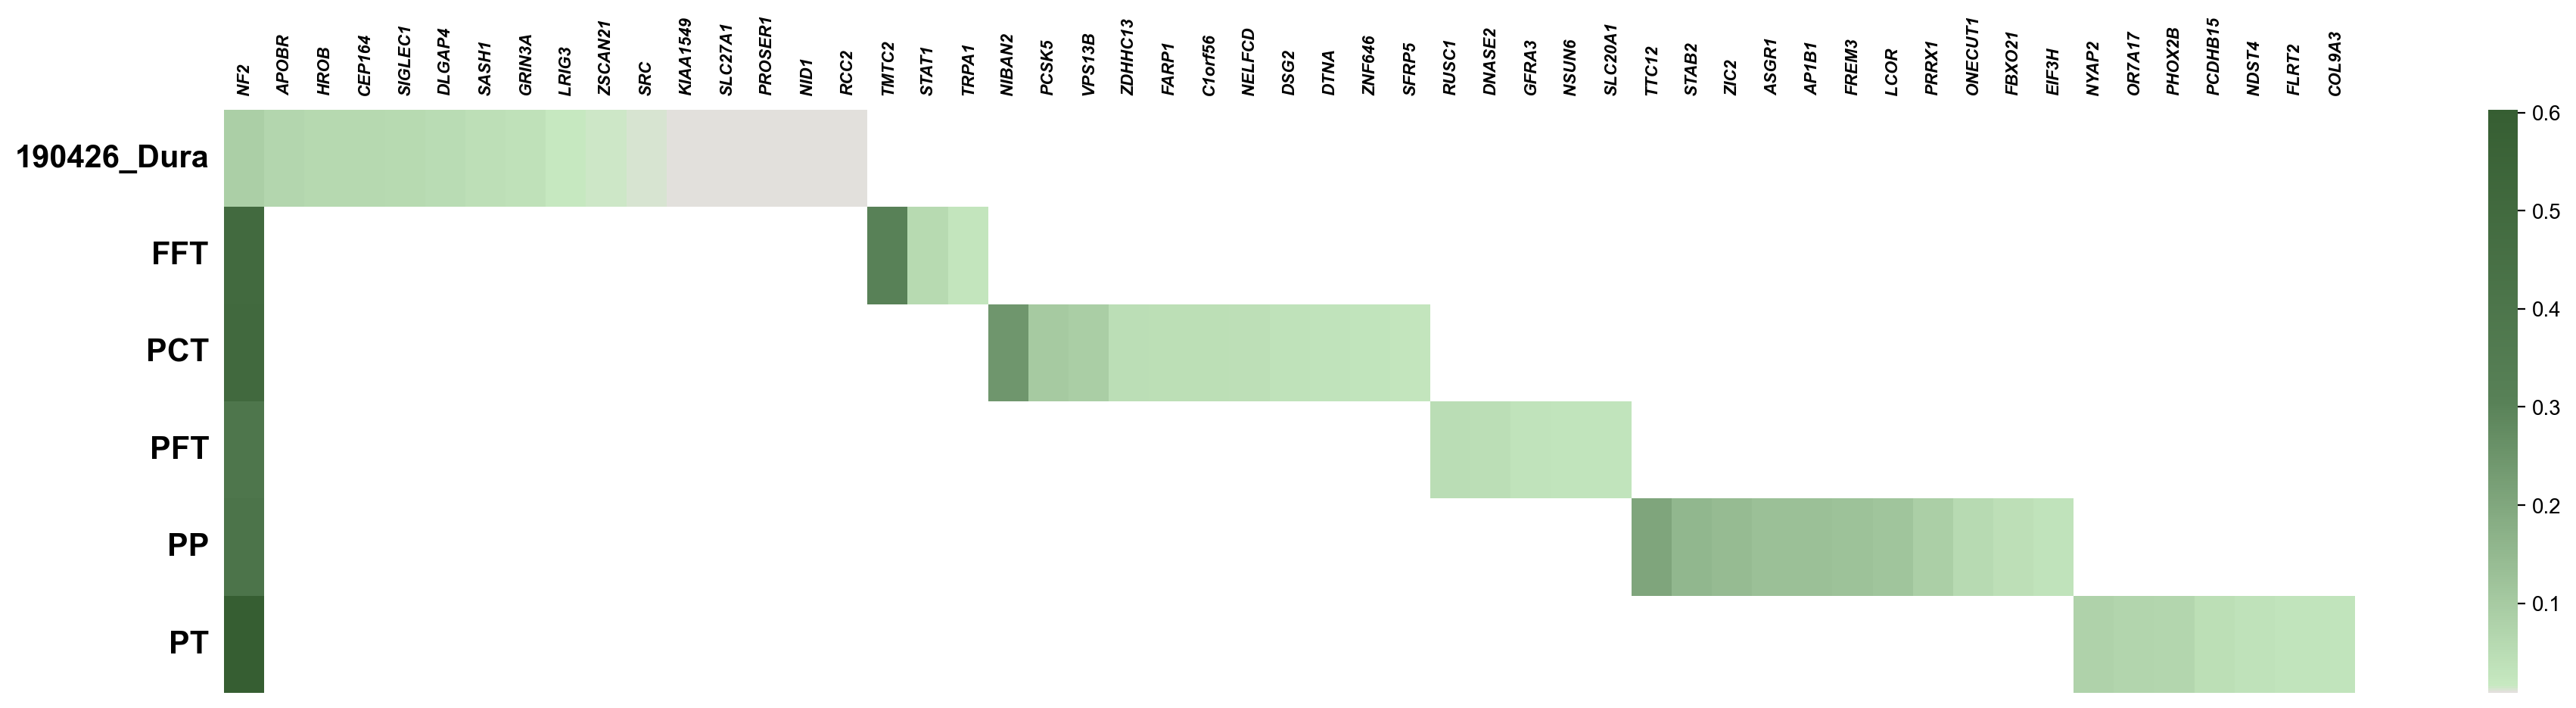

In [41]:
#def HEATMAP_VISUALIZATION (df, title, Output_filename, **kwargs):
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcl
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams["font.family"] = 'arial'

# Define the colors
colors = [  "#E2E0DC", "#C7E9C1", "#588157", "#365E32"]
fig, ax = plt.subplots ( nrows = 1, ncols = 1, figsize =( 20 , 5 ))

positions = [0, 0.01, 0.5, 1]  # Define the positions for each color
# Create the colormap
cmap = LinearSegmentedColormap.from_list('custom_cmap', list(zip(positions, colors)))

fig.subplots_adjust ( wspace = 0.4, bottom = 0.03, top = 0.8, left = 0.1, right = 0.98)
fig.set_facecolor('white')

#sns.heatmap (df , cmap = cmap, linewidths = 0.5, linecolor = "black", annot = df, annot_kws={"size": 25 / np.sqrt(len(df))} )   # fmt=".2f", 
sns.heatmap (df , cmap = cmap, linewidths = 0, linecolor = "black")   # fmt=".2f", 
    
    
#fig.suptitle ( title, fontsize = 5, fontweight = "bold", ha = "left", x = 0.5 )
ax.set_xlabel ( "")
ax.set_ylabel ( "")
ax.set_xticklabels( [ i.get_text().split("_")[0] for i in ax.get_xticklabels()], ha = 'center', fontdict = {"fontsize": 8, "fontweight" : "semibold", "style": "italic" } )  # HUGO_SYMBOL만 label로 붙이자
ax.tick_params(axis = 'x',  rotation = 90, bottom = False, top = False)
ax.set_yticklabels( [ i.get_text().replace( "190426_Tumor_" , "" ) for i in ax.get_yticklabels()],  va = 'center', fontdict = {"fontsize": 15, "fontweight" : "semibold" } )
ax.tick_params(axis = 'y')
    

plt.tick_params(axis='both', which='major', left = False, labelbottom = False, bottom = False, top = False, labeltop = True)

fig.savefig ( "/data/project/Meningioma/script/03.Variant_calling&Annotation/★comut_sorted_heatmap.jpg", dpi = 300)
fig.savefig ( "/data/project/Meningioma/script/03.Variant_calling&Annotation/★comut_sorted_heatmap.pdf", dpi = 300)

## Hierichial clustering

/home/goldpm1/miniconda3/envs/cnvpytor/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


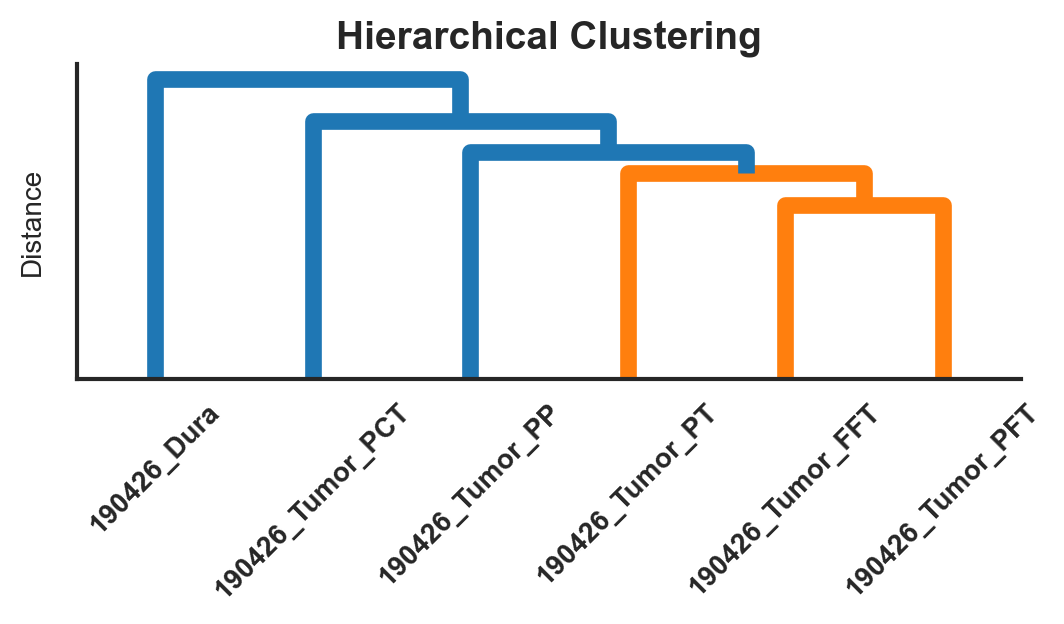

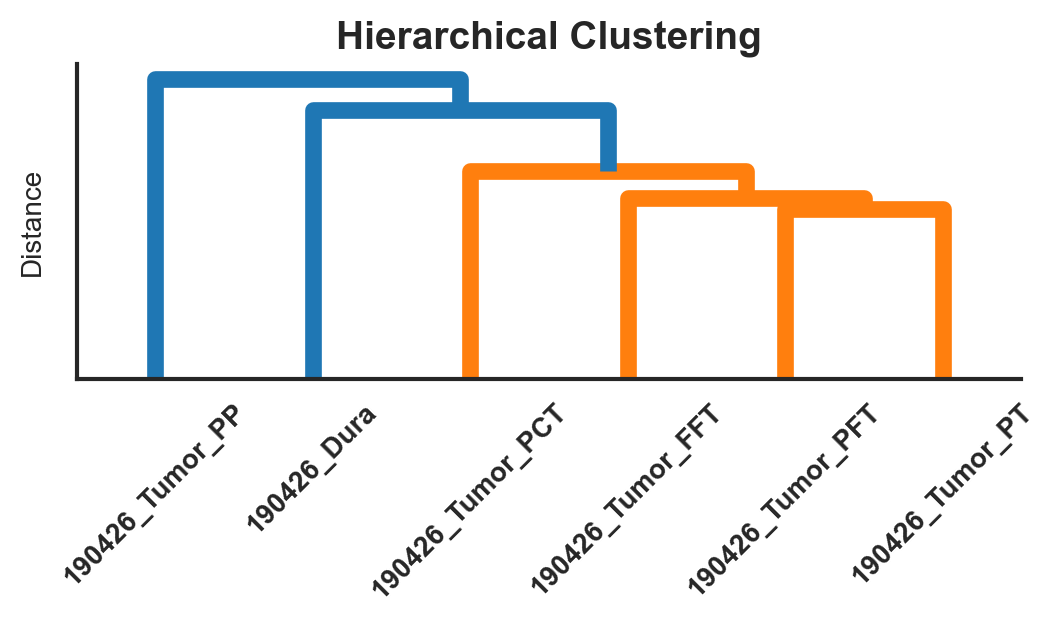

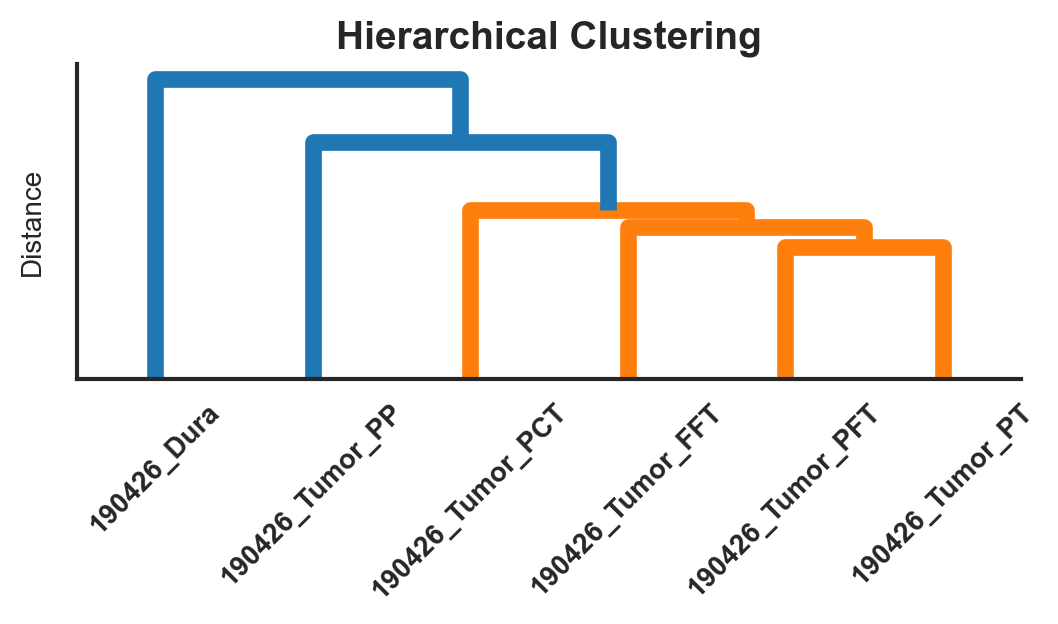

In [56]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

def map_to_one(x):
    if x != 0:
        return 1
    else:
        return x

#1.    
d_binary = pd.pivot_table(mutation_data_all_dedup.loc [:, ["Hugo_Symbol", "Tumor_Sample_Barcode", "VAF"]], index='Hugo_Symbol', columns='Tumor_Sample_Barcode').fillna ( "0" ) ["VAF"].astype(float)
d_binary = d_binary.applymap(map_to_one).astype(int)

#2.
d_vaf = pd.pivot_table(mutation_data_all_dedup.loc [:, ["Hugo_Symbol", "Tumor_Sample_Barcode", "VAF"]], index='Hugo_Symbol', columns='Tumor_Sample_Barcode').fillna ( "0" ) ["VAF"]

#3. scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
d_scale = d_vaf
scaler.fit(d_scale)
d_scale = scaler.transform( d_scale )  # Transform the data



# Plot the dendrogram
def HierichialClustering (df, colnames, OUTPUT_FILEPATH ):
    fig, ax = plt.subplots(1, 1, figsize = (15 / 2.54, 8 / 2.54))
    fig.subplots_adjust (wspace = 0.2, hspace = 0.8, bottom = 0.35, top = 0.85, left = 0.15, right = 0.95)
    sns.set_style("white")
    plt.rcParams['lines.linewidth'] = 6
    plt.rcParams["font.family"] = 'arial'

    def my_label_func ( leaf_label ):  # 0, 1, 2, 3
        return colnames [leaf_label ]

    D = scipy.cluster.hierarchy.dendrogram(
        scipy.cluster.hierarchy.linkage( df.T, method = 'ward', metric = 'euclidean'),
        leaf_label_func = my_label_func,  # column 이름 정하기
        leaf_rotation = 90  # Rotate labels for better readability
    )

    ax.tick_params(axis = 'x', rotation = 45)
    ax.set_xticklabels ( ax.get_xticklabels() , fontsize = 10, fontweight = "bold"  ) 
    ax.set_yticklabels ( ax.get_yticklabels() , fontsize = 10, fontweight = "bold"  ) 
    ax.set_title('Hierarchical Clustering', fontweight = "semibold", fontsize = 14)
    ax.set_ylabel('Distance')

    for axis in ['left','bottom', 'right', 'top']:
        ax.spines[axis].set_linewidth (1.5)
    sns.despine ( top = True, right = True, ax = ax)
    #plt.savefig (OUTPUT_FILEPATH)

################################################################################################################


HierichialClustering ( d_binary ,  list ( d_binary.columns ),  "/data/project/Meningioma/script/03.Variant_calling&Annotation/190426.dendrogram.binary.pdf" )       # Binary 를 넣었을 때
HierichialClustering ( d_vaf,  list ( d_binary.columns ),  "/data/project/Meningioma/script/03.Variant_calling&Annotation/190426.dendrogram.vaf.pdf" )                       # Scaling 한 AF 를 넣었을 때
HierichialClustering ( d_scale, list ( d_binary.columns ),   "/data/project/Meningioma/script/03.Variant_calling&Annotation/190426.dendrogram.scale.pdf" )        # Scaling 안한 AF를 넣었을 떄

Matplotlib is building the font cache; this may take a moment.


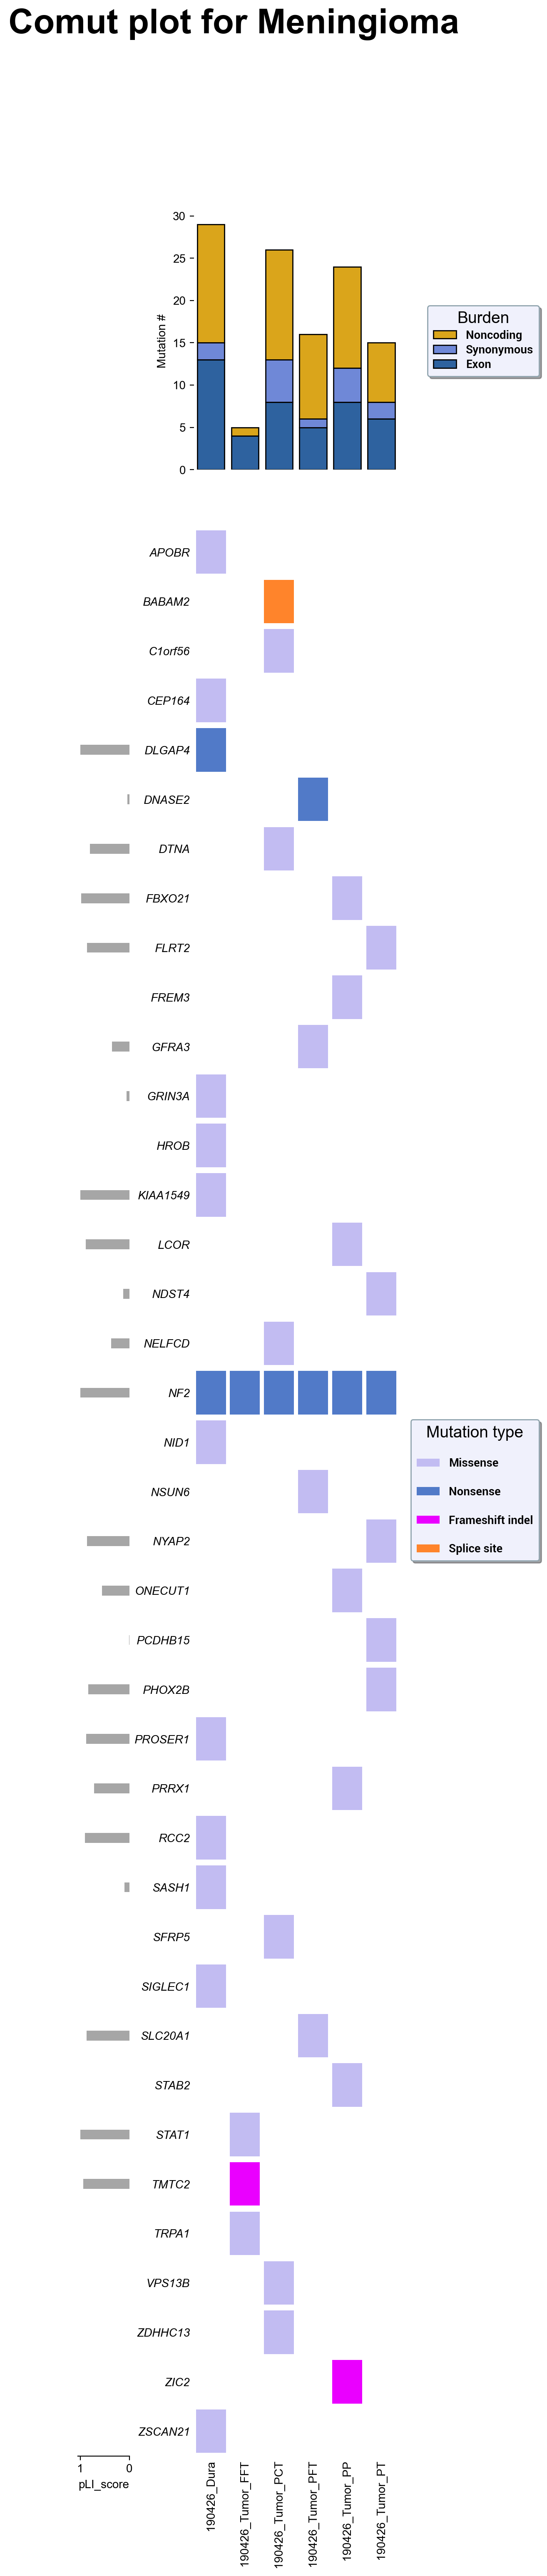

In [16]:
# # #3. Add pandas data to the CoMut object
fig = plt.figure(figsize=(5, 35), tight_layout=False)


#comut_meningioma.add_sample_indicators ( add_sample_indicator (mutation_df), name = "Same patient", plot_kwargs = {'color': 'black', 'marker': 'o', 'linewidth': 1, 'markersize': 5} )

comut_meningioma.add_categorical_data(mutation_df, name = 'Mutation type' ,
                                                            category_order = sorted ( list ( set(mutation_df["category"]) ) , reverse = True) , 
                                                            #category_order = list(pd.unique(pd.merge (mutation_df, pLI_df, left_on = "category", right_on ="Hugo_Symbol", how = "left").fillna(0).sort_values(by = "pLI_score", ascending = True)["category"])),   # pLI score를 정렬한 list
                                                            priority =  ["Splice site", "promoter"], value_order = ["Splice site", "Nonsense", "Missense", "promoter"], 
                                                            mapping = mut_mapping, 
                                                            borders = ["CTCF_binding_site"],  
                                                            tick_style = "oblique")   # value_order : 왼쪽 위 triangle에 뭐부터 넣을지    # priority : multiple에 속해 있을 때 얘를 꺼낼지

comut_meningioma.add_side_bar_data( add_sidebar(mutation_df), paired_name = 'Mutation type', name = 'pLI_score',  mapping = {"pLI_score" : "grey"}, xlabel = 'pLI_score', position = 'left', bar_kwargs = {"height" : 0.2, "alpha" : 0.7, "capstyle" : "projecting", "capsize" : 0.5})   

# comut_meningioma.add_continuous_data(add_tumor_purity (mutation_df), name = 'Tumor purity', 
#                                                                   mapping = "Purples", 
#                                                                   cat_mapping = {'Absent': {'facecolor': 'red'}}, 
#                                                                   value_range = (0, 1)  )

comut_meningioma.add_bar_data( add_bar(mutation_data_all_dedup)[0], name = 'Burden', mapping = add_bar(mutation_data_all_dedup)[1] , stacked = True, ylabel = 'Mutation #', bar_kwargs = {'width': 0.8, 'edgecolor': 'black'} )   





# 4. 그림 그려주고
comut_meningioma.plot_comut(x_padding = 0.06, y_padding = 0.06, tri_padding = 0.05, 
                                                    heights = {'Burden': 2, 'Tumor purity' : 0.7, 'Mutation type': 15}, widths =[0.2, 0.8], 
                                                    wspace = 0.5, hspace = 0.05,  subplot_hspace = 0.05, 
                                                    fig = fig,  spec=gs[0])      # height : bar는 default가3,  category는 기본이 1,  width : side barplot vs main figure 의 폭 비율 


# 5. Legend 달아주기   title_fontproperties = matplotlib.font_manager.FontProperties(fname=font_dir+"/Halyard Text Medium.ttf", size = 20)
legend_burden = comut_meningioma.add_axis_legend(name = 'Burden' , loc = "right", bbox_to_anchor = (1.7, 0.5), title = 'Burden', title_fontsize = 14, title_align = "center", 
                                                                                        frameon = True, facecolor = "#f0f1fc", edgecolor = "#90a4ae", shadow = True, borderpad = 0.5,        # borderpad : border 안쪽의 whiespace
                                                                                        order = ["Noncoding", "Synonymous",  "Exon"], labelspacing = 0.3,
                                                                                        fontsize = 12,  prop = matplotlib.font_manager.FontProperties(fname=font_dir+"/Apple SD Gothic Neo Bold.ttf"))
legend_main_figure = comut_meningioma.add_axis_legend(name = 'Mutation type' , loc = "right", bbox_to_anchor = (1.7, 0.5), title = 'Mutation type',  title_fontsize = 14, title_align = "center", 
                                                                                        frameon = True, facecolor = "#f0f1fc", edgecolor = "#90a4ae", shadow = True, borderpad = 0.5,
                                                                                        order = Variant_Classification,  labelspacing = 1.5, 
                                                                                        fontsize = 12, prop = matplotlib.font_manager.FontProperties(fname=font_dir+"/Apple SD Gothic Neo Bold.ttf"))

#comut_meningioma.add_unified_legend(bbox_to_anchor = (1.1,1.1), frameon = True)

fig.suptitle("Comut plot for Meningioma", fontsize = 30, fontweight = "heavy", ha = "center",  y = 0.95, fontproperties = matplotlib.font_manager.FontProperties(fname=font_dir+"/arialbd.ttf"))  


#5. 파일로 저장하기
comut_meningioma.figure.savefig("/data/project/Meningioma/script/03.Variant_calling&Annotation/★comut_plot.jpg", dpi = 300, bbox_inches = 'tight')
comut_meningioma.figure.savefig("/data/project/Meningioma/04.mutect/★comut_plot.jpg", dpi = 300, bbox_inches = 'tight')
comut_meningioma.figure.savefig("/data/project/Meningioma/script/03.Variant_calling&Annotation/★comut_plot.pdf", dpi = 300, bbox_inches = 'tight')
comut_meningioma.figure.savefig("/data/project/Meningioma/04.mutect/★comut_plot.pdf", dpi = 300, bbox_inches = 'tight')